In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from deepthink.optimizers import Adam
from deepthink.layers import Dense
from deepthink.model import Model
from deepthink.activations import ReLU,  Sigmoid
from deepthink.loss import MeanSquaredError

# Set default matplotlib style
plt.style.use('ggplot')

## House price regression example

The purpose of this notebook is to demonstrate how to train a model on a regression task. The dataset used is the California Housing Prices dataset from the StatLib repository ([see this link for more info](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)) which can be downloaded from [here](https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv). This is a dataset of house prices from the 1990 California census and the objective is to predict the house price given several other features.

For this notebook I have taken inspiration from Chaper 2 of the excellent book ["Hands-On Machine Learning with Scikit-Learn and TensorFlow"](https://www.amazon.co.uk/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1098125975) by Aurélien Géron. I would strongly recommend this book to beginners looking to learn machine learning. It's also a great reference point for experienced machine learning practitioners.

The goal of this notebook is to demonstrate functionally on a regression task, not to set state-of-the-art results. I have therefore spent minimal time cleaning the data, feature selection, etc. For a more detailed look I would refer the reader to Chaper 2 of Hands-On Machine Learning with Scikit-Learn and TensorFlow.

## Loading the data

The function will below will download the dataset and save it if does not already exist. Subsequent calls will load the dataset from the local machine. 

In [2]:
def load_housing_data(filepath=None):
    """
    Load California Housing dataset.

    It will download the dataset if it does not already exist and then
    subsequent calls will load from the local machine.

    Parameters
    ----------
    filepath : str
        The location to save/load the dataset.

    References
    ----------
    - https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html
    """
    url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
    if filepath:
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
        else:
            print('Downloading dataset...')
            df = pd.read_csv(url)
            df.to_csv(filepath, index=False)
    else:
        print('Downloading dataset...')
        df = pd.read_csv(url)

    return df

In [3]:
df = load_housing_data('../Data/CaliforniaHousing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.shape

(20640, 10)

In [5]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
# Drop rows with NaNs
df = df[~df.isnull().any(axis=1)]
# Drop categorical column
df.drop(columns=['ocean_proximity'], inplace=True)

In [7]:
# Create new features
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

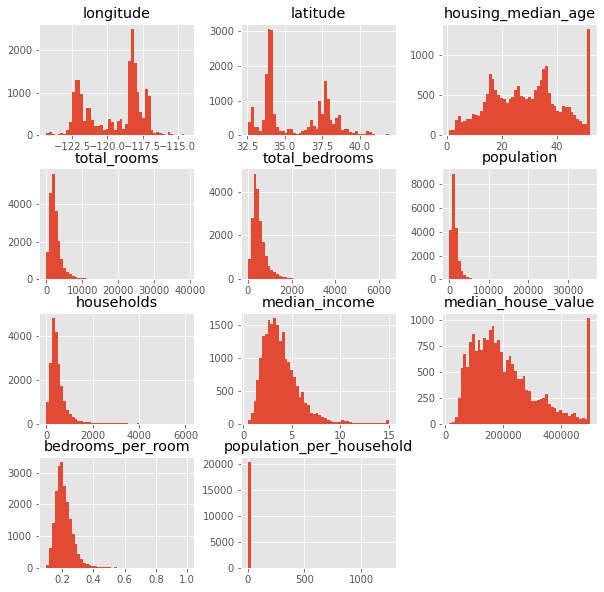

In [8]:
# Use histogram to visualize distributions
df.hist(bins=50, figsize=(10, 10))

plt.show()

In [9]:
# Log-transform skewed columns
log_cols = ['total_rooms', 'total_bedrooms', 'population', 'households',
            'bedrooms_per_room', 'population_per_household']

for col in log_cols:
    df[f'log_{col}'] = df[col].apply(np.log1p)

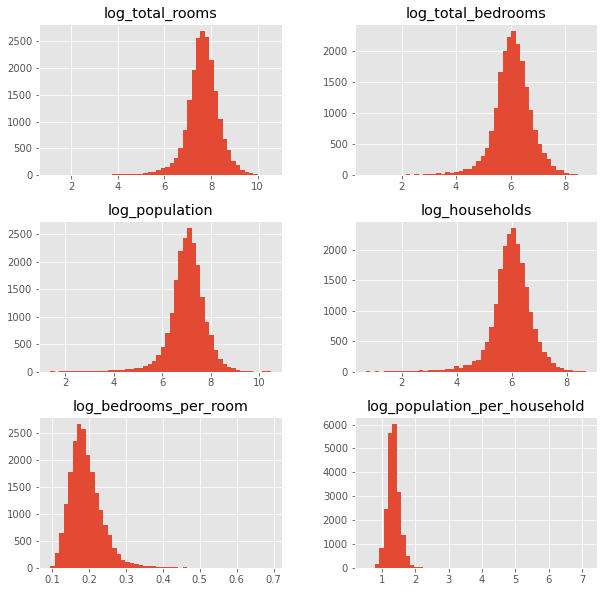

In [10]:
# View histograms of the log-transformed columns
new_cols = df.columns[df.columns.str.startswith('log')]
df[new_cols].hist(bins=50, figsize=(10, 10));

In [11]:
df.corr()['median_house_value'].sort_values(ascending=False)

median_house_value              1.000000
median_income                   0.688355
log_total_rooms                 0.158506
total_rooms                     0.133294
housing_median_age              0.106432
log_households                  0.072765
households                      0.064894
log_total_bedrooms              0.053311
total_bedrooms                  0.049686
log_population                 -0.021904
population_per_household       -0.023639
population                     -0.025300
longitude                      -0.045398
latitude                       -0.144638
log_population_per_household   -0.246415
bedrooms_per_room              -0.255880
log_bedrooms_per_room          -0.271949
Name: median_house_value, dtype: float64

In [12]:
# Normalize data
# store target min and max for reversing process
target_min = df['median_house_value'].min()
target_max = df['median_house_value'].max()
df = (df - df.min()) / (df.max() - df.min())

In [13]:
feature_cols = ['median_income', 'log_bedrooms_per_room', 'latitude',
                'longitude', 'log_population_per_household',
                'housing_median_age']
df[feature_cols].corr()

,median_income,log_bedrooms_per_room,latitude,longitude,log_population_per_household,housing_median_age
median_income,1.000000,-0.639181,-0.079626,-0.015550,-0.029493,-0.118278
log_bedrooms_per_room,-0.639181,1.000000,-0.113675,0.093296,-0.038605,0.140446
latitude,-0.079626,-0.113675,1.000000,-0.924616,-0.132598,0.011899
longitude,-0.015550,0.093296,-0.924616,1.000000,0.144243,-0.109357
log_population_per_household,-0.029493,-0.038605,-0.132598,0.144243,1.000000,-0.007336
housing_median_age,-0.118278,0.140446,0.011899,-0.109357,-0.007336,1.000000


In [14]:
# Convert DataFrame to Numpy arrays
X_data = df[feature_cols].values
# y-data reshaped to column array from 1D
y_data = df['median_house_value'].values.reshape(-1, 1)

In [15]:
# Splitting into training & test data
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y_data,
                                                    test_size=0.25)
print(X_train.shape, X_test.shape)

(15324, 6) (5109, 6)


In [16]:
# Define hyperparameters
input_dims = X_train.shape[1]
learning_rate = 0.005
batch_size = 128
init_type = 'he_uniform'

In [17]:
# Building the model
opt = Adam(learning_rate)
model = Model(opt, cost=MeanSquaredError(),
              batch_size=batch_size,
              metrics=['RMSE'])
model.add_layer(Dense(32, n_inputs=input_dims,
                      weight_init=init_type))
model.add_layer(ReLU())
model.add_layer(Dense(32, weight_init=init_type))
model.add_layer(ReLU())
model.add_layer(Dense(1, weight_init=init_type))
model.add_layer(Sigmoid())

model.initialize()

In [18]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Dense Layer               (None, 32)                          192
ReLU Activation           (None, 32)                            0
Dense Layer               (None, 32)                         1024
ReLU Activation           (None, 32)                            0
Dense Layer               (None, 1)                            32
Sigmoid Activation        (None, 1)                             0
Total params: 1,313


In [19]:
history = model.train((X_train, y_train),
                      (X_test, y_test), epochs=100)

100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1341.00it/s]


Epoch: 1/100, elapsed-time: 0.12s - loss: 0.0214 - RMSE: 0.0991 - val_loss: 0.0218 - val_RMSE: 0.0989 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1354.47it/s]


Epoch: 2/100, elapsed-time: 0.22s - loss: 0.0170 - RMSE: 0.0925 - val_loss: 0.0182 - val_RMSE: 0.0899 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1334.62it/s]


Epoch: 3/100, elapsed-time: 0.32s - loss: 0.0167 - RMSE: 0.0916 - val_loss: 0.0162 - val_RMSE: 0.0921 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1379.81it/s]


Epoch: 4/100, elapsed-time: 0.42s - loss: 0.0159 - RMSE: 0.0885 - val_loss: 0.0161 - val_RMSE: 0.0858 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1272.96it/s]


Epoch: 5/100, elapsed-time: 0.53s - loss: 0.0159 - RMSE: 0.0884 - val_loss: 0.0166 - val_RMSE: 0.0865 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1220.11it/s]


Epoch: 6/100, elapsed-time: 0.64s - loss: 0.0158 - RMSE: 0.0884 - val_loss: 0.0158 - val_RMSE: 0.0844 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1410.73it/s]

Epoch: 7/100, elapsed-time: 0.73s - loss: 0.0156 - RMSE: 0.0879 - val_loss: 0.0149 - val_RMSE: 0.0842 - 

100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1450.01it/s]


Epoch: 8/100, elapsed-time: 0.82s - loss: 0.0153 - RMSE: 0.0865 - val_loss: 0.0148 - val_RMSE: 0.0840 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1239.19it/s]


Epoch: 9/100, elapsed-time: 0.93s - loss: 0.0151 - RMSE: 0.0861 - val_loss: 0.0155 - val_RMSE: 0.0881 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1298.00it/s]


Epoch: 10/100, elapsed-time: 1.04s - loss: 0.0155 - RMSE: 0.0874 - val_loss: 0.0145 - val_RMSE: 0.0836 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1232.97it/s]


Epoch: 11/100, elapsed-time: 1.14s - loss: 0.0150 - RMSE: 0.0856 - val_loss: 0.0150 - val_RMSE: 0.0889 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1398.27it/s]


Epoch: 12/100, elapsed-time: 1.25s - loss: 0.0151 - RMSE: 0.0865 - val_loss: 0.0165 - val_RMSE: 0.0976 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1476.17it/s]


Epoch: 13/100, elapsed-time: 1.35s - loss: 0.0147 - RMSE: 0.0847 - val_loss: 0.0142 - val_RMSE: 0.0845 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1401.49it/s]


Epoch: 14/100, elapsed-time: 1.46s - loss: 0.0145 - RMSE: 0.0842 - val_loss: 0.0143 - val_RMSE: 0.0823 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1363.04it/s]


Epoch: 15/100, elapsed-time: 1.56s - loss: 0.0143 - RMSE: 0.0835 - val_loss: 0.0141 - val_RMSE: 0.0825 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1483.68it/s]


Epoch: 16/100, elapsed-time: 1.65s - loss: 0.0144 - RMSE: 0.0835 - val_loss: 0.0137 - val_RMSE: 0.0814 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1543.67it/s]


Epoch: 17/100, elapsed-time: 1.74s - loss: 0.0143 - RMSE: 0.0834 - val_loss: 0.0137 - val_RMSE: 0.0802 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1262.35it/s]


Epoch: 18/100, elapsed-time: 1.84s - loss: 0.0141 - RMSE: 0.0825 - val_loss: 0.0141 - val_RMSE: 0.0815 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1528.33it/s]


Epoch: 19/100, elapsed-time: 1.93s - loss: 0.0141 - RMSE: 0.0828 - val_loss: 0.0137 - val_RMSE: 0.0816 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1406.50it/s]


Epoch: 20/100, elapsed-time: 2.02s - loss: 0.0143 - RMSE: 0.0833 - val_loss: 0.0151 - val_RMSE: 0.0913 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1428.14it/s]


Epoch: 21/100, elapsed-time: 2.12s - loss: 0.0140 - RMSE: 0.0823 - val_loss: 0.0137 - val_RMSE: 0.0809 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1529.82it/s]


Epoch: 22/100, elapsed-time: 2.21s - loss: 0.0140 - RMSE: 0.0824 - val_loss: 0.0139 - val_RMSE: 0.0787 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1412.67it/s]


Epoch: 23/100, elapsed-time: 2.30s - loss: 0.0140 - RMSE: 0.0824 - val_loss: 0.0133 - val_RMSE: 0.0792 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1539.73it/s]


Epoch: 24/100, elapsed-time: 2.39s - loss: 0.0138 - RMSE: 0.0814 - val_loss: 0.0134 - val_RMSE: 0.0813 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1524.81it/s]


Epoch: 25/100, elapsed-time: 2.49s - loss: 0.0137 - RMSE: 0.0811 - val_loss: 0.0136 - val_RMSE: 0.0836 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1345.79it/s]


Epoch: 26/100, elapsed-time: 2.59s - loss: 0.0137 - RMSE: 0.0811 - val_loss: 0.0134 - val_RMSE: 0.0784 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1503.76it/s]

Epoch: 27/100, elapsed-time: 2.69s - loss: 0.0139 - RMSE: 0.0815 - val_loss: 0.0146 - val_RMSE: 0.0801 - 

100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1546.29it/s]


Epoch: 28/100, elapsed-time: 2.79s - loss: 0.0138 - RMSE: 0.0812 - val_loss: 0.0133 - val_RMSE: 0.0786 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1441.33it/s]

Epoch: 29/100, elapsed-time: 2.89s - loss: 0.0136 - RMSE: 0.0804 - val_loss: 0.0133 - val_RMSE: 0.0812 - 

100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1483.09it/s]


Epoch: 30/100, elapsed-time: 2.99s - loss: 0.0134 - RMSE: 0.0795 - val_loss: 0.0146 - val_RMSE: 0.0793 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1317.58it/s]


Epoch: 31/100, elapsed-time: 3.10s - loss: 0.0135 - RMSE: 0.0799 - val_loss: 0.0132 - val_RMSE: 0.0796 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1525.64it/s]


Epoch: 32/100, elapsed-time: 3.19s - loss: 0.0133 - RMSE: 0.0791 - val_loss: 0.0132 - val_RMSE: 0.0791 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1536.26it/s]


Epoch: 33/100, elapsed-time: 3.28s - loss: 0.0134 - RMSE: 0.0795 - val_loss: 0.0130 - val_RMSE: 0.0796 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1322.11it/s]


Epoch: 34/100, elapsed-time: 3.39s - loss: 0.0132 - RMSE: 0.0792 - val_loss: 0.0129 - val_RMSE: 0.0774 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1517.44it/s]


Epoch: 35/100, elapsed-time: 3.49s - loss: 0.0133 - RMSE: 0.0791 - val_loss: 0.0127 - val_RMSE: 0.0768 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1419.60it/s]


Epoch: 36/100, elapsed-time: 3.59s - loss: 0.0135 - RMSE: 0.0799 - val_loss: 0.0135 - val_RMSE: 0.0817 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1581.82it/s]


Epoch: 37/100, elapsed-time: 3.68s - loss: 0.0132 - RMSE: 0.0789 - val_loss: 0.0134 - val_RMSE: 0.0778 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1547.34it/s]


Epoch: 38/100, elapsed-time: 3.78s - loss: 0.0135 - RMSE: 0.0799 - val_loss: 0.0136 - val_RMSE: 0.0768 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1353.91it/s]


Epoch: 39/100, elapsed-time: 3.88s - loss: 0.0132 - RMSE: 0.0792 - val_loss: 0.0127 - val_RMSE: 0.0755 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1529.13it/s]


Epoch: 40/100, elapsed-time: 3.97s - loss: 0.0130 - RMSE: 0.0780 - val_loss: 0.0129 - val_RMSE: 0.0782 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1548.54it/s]


Epoch: 41/100, elapsed-time: 4.06s - loss: 0.0133 - RMSE: 0.0794 - val_loss: 0.0139 - val_RMSE: 0.0877 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1420.37it/s]


Epoch: 42/100, elapsed-time: 4.17s - loss: 0.0132 - RMSE: 0.0790 - val_loss: 0.0138 - val_RMSE: 0.0857 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1528.28it/s]


Epoch: 43/100, elapsed-time: 4.27s - loss: 0.0130 - RMSE: 0.0784 - val_loss: 0.0132 - val_RMSE: 0.0826 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1418.79it/s]


Epoch: 44/100, elapsed-time: 4.37s - loss: 0.0130 - RMSE: 0.0781 - val_loss: 0.0125 - val_RMSE: 0.0773 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1581.35it/s]


Epoch: 45/100, elapsed-time: 4.47s - loss: 0.0130 - RMSE: 0.0778 - val_loss: 0.0136 - val_RMSE: 0.0765 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1543.20it/s]


Epoch: 46/100, elapsed-time: 4.56s - loss: 0.0129 - RMSE: 0.0780 - val_loss: 0.0123 - val_RMSE: 0.0761 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1316.00it/s]


Epoch: 47/100, elapsed-time: 4.67s - loss: 0.0127 - RMSE: 0.0769 - val_loss: 0.0126 - val_RMSE: 0.0772 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1526.82it/s]


Epoch: 48/100, elapsed-time: 4.76s - loss: 0.0131 - RMSE: 0.0781 - val_loss: 0.0130 - val_RMSE: 0.0764 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1538.80it/s]


Epoch: 49/100, elapsed-time: 4.86s - loss: 0.0128 - RMSE: 0.0776 - val_loss: 0.0124 - val_RMSE: 0.0755 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1426.60it/s]


Epoch: 50/100, elapsed-time: 4.96s - loss: 0.0129 - RMSE: 0.0773 - val_loss: 0.0128 - val_RMSE: 0.0797 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1514.36it/s]


Epoch: 51/100, elapsed-time: 5.06s - loss: 0.0129 - RMSE: 0.0777 - val_loss: 0.0133 - val_RMSE: 0.0769 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1380.12it/s]


Epoch: 52/100, elapsed-time: 5.16s - loss: 0.0128 - RMSE: 0.0773 - val_loss: 0.0129 - val_RMSE: 0.0786 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1500.11it/s]


Epoch: 53/100, elapsed-time: 5.25s - loss: 0.0128 - RMSE: 0.0774 - val_loss: 0.0126 - val_RMSE: 0.0760 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1549.94it/s]


Epoch: 54/100, elapsed-time: 5.35s - loss: 0.0126 - RMSE: 0.0765 - val_loss: 0.0125 - val_RMSE: 0.0747 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1334.47it/s]


Epoch: 55/100, elapsed-time: 5.45s - loss: 0.0125 - RMSE: 0.0763 - val_loss: 0.0122 - val_RMSE: 0.0744 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1469.68it/s]


Epoch: 56/100, elapsed-time: 5.55s - loss: 0.0127 - RMSE: 0.0767 - val_loss: 0.0136 - val_RMSE: 0.0768 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1306.88it/s]


Epoch: 57/100, elapsed-time: 5.66s - loss: 0.0127 - RMSE: 0.0769 - val_loss: 0.0127 - val_RMSE: 0.0769 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1546.94it/s]


Epoch: 58/100, elapsed-time: 5.75s - loss: 0.0127 - RMSE: 0.0769 - val_loss: 0.0128 - val_RMSE: 0.0750 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1600.69it/s]


Epoch: 59/100, elapsed-time: 5.84s - loss: 0.0128 - RMSE: 0.0773 - val_loss: 0.0125 - val_RMSE: 0.0758 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1438.06it/s]


Epoch: 60/100, elapsed-time: 5.94s - loss: 0.0128 - RMSE: 0.0771 - val_loss: 0.0130 - val_RMSE: 0.0759 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1537.71it/s]


Epoch: 61/100, elapsed-time: 6.03s - loss: 0.0126 - RMSE: 0.0767 - val_loss: 0.0129 - val_RMSE: 0.0822 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1604.88it/s]


Epoch: 62/100, elapsed-time: 6.12s - loss: 0.0125 - RMSE: 0.0762 - val_loss: 0.0134 - val_RMSE: 0.0764 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1400.35it/s]


Epoch: 63/100, elapsed-time: 6.22s - loss: 0.0126 - RMSE: 0.0767 - val_loss: 0.0123 - val_RMSE: 0.0765 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1525.57it/s]


Epoch: 64/100, elapsed-time: 6.31s - loss: 0.0127 - RMSE: 0.0772 - val_loss: 0.0125 - val_RMSE: 0.0754 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1392.57it/s]


Epoch: 65/100, elapsed-time: 6.42s - loss: 0.0123 - RMSE: 0.0756 - val_loss: 0.0123 - val_RMSE: 0.0740 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1521.37it/s]


Epoch: 66/100, elapsed-time: 6.52s - loss: 0.0125 - RMSE: 0.0760 - val_loss: 0.0122 - val_RMSE: 0.0731 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1363.27it/s]


Epoch: 67/100, elapsed-time: 6.62s - loss: 0.0125 - RMSE: 0.0762 - val_loss: 0.0122 - val_RMSE: 0.0732 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1021.24it/s]


Epoch: 68/100, elapsed-time: 6.75s - loss: 0.0126 - RMSE: 0.0765 - val_loss: 0.0125 - val_RMSE: 0.0784 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1383.34it/s]


Epoch: 69/100, elapsed-time: 6.86s - loss: 0.0126 - RMSE: 0.0767 - val_loss: 0.0121 - val_RMSE: 0.0741 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1084.19it/s]


Epoch: 70/100, elapsed-time: 6.99s - loss: 0.0123 - RMSE: 0.0755 - val_loss: 0.0122 - val_RMSE: 0.0745 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1217.37it/s]


Epoch: 71/100, elapsed-time: 7.10s - loss: 0.0124 - RMSE: 0.0760 - val_loss: 0.0126 - val_RMSE: 0.0778 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1108.97it/s]


Epoch: 72/100, elapsed-time: 7.23s - loss: 0.0124 - RMSE: 0.0758 - val_loss: 0.0121 - val_RMSE: 0.0736 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1280.24it/s]


Epoch: 73/100, elapsed-time: 7.34s - loss: 0.0126 - RMSE: 0.0766 - val_loss: 0.0130 - val_RMSE: 0.0827 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1093.70it/s]


Epoch: 74/100, elapsed-time: 7.46s - loss: 0.0124 - RMSE: 0.0758 - val_loss: 0.0120 - val_RMSE: 0.0739 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1287.47it/s]


Epoch: 75/100, elapsed-time: 7.57s - loss: 0.0123 - RMSE: 0.0755 - val_loss: 0.0124 - val_RMSE: 0.0786 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1202.41it/s]


Epoch: 76/100, elapsed-time: 7.70s - loss: 0.0123 - RMSE: 0.0754 - val_loss: 0.0121 - val_RMSE: 0.0740 - 


100%|████████████████████████████████████████| 119/119 [00:00<00:00, 833.75it/s]


Epoch: 77/100, elapsed-time: 7.87s - loss: 0.0123 - RMSE: 0.0757 - val_loss: 0.0122 - val_RMSE: 0.0756 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1372.04it/s]


Epoch: 78/100, elapsed-time: 7.97s - loss: 0.0124 - RMSE: 0.0761 - val_loss: 0.0123 - val_RMSE: 0.0733 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1490.99it/s]


Epoch: 79/100, elapsed-time: 8.07s - loss: 0.0123 - RMSE: 0.0753 - val_loss: 0.0124 - val_RMSE: 0.0775 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1587.31it/s]


Epoch: 80/100, elapsed-time: 8.16s - loss: 0.0125 - RMSE: 0.0764 - val_loss: 0.0133 - val_RMSE: 0.0751 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1389.48it/s]


Epoch: 81/100, elapsed-time: 8.26s - loss: 0.0124 - RMSE: 0.0762 - val_loss: 0.0121 - val_RMSE: 0.0732 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1510.98it/s]


Epoch: 82/100, elapsed-time: 8.36s - loss: 0.0124 - RMSE: 0.0757 - val_loss: 0.0121 - val_RMSE: 0.0757 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1582.15it/s]


Epoch: 83/100, elapsed-time: 8.44s - loss: 0.0125 - RMSE: 0.0763 - val_loss: 0.0128 - val_RMSE: 0.0745 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1156.96it/s]


Epoch: 84/100, elapsed-time: 8.57s - loss: 0.0122 - RMSE: 0.0752 - val_loss: 0.0120 - val_RMSE: 0.0737 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1266.72it/s]


Epoch: 85/100, elapsed-time: 8.68s - loss: 0.0123 - RMSE: 0.0756 - val_loss: 0.0132 - val_RMSE: 0.0752 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1342.34it/s]


Epoch: 86/100, elapsed-time: 8.78s - loss: 0.0122 - RMSE: 0.0755 - val_loss: 0.0131 - val_RMSE: 0.0759 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1402.38it/s]


Epoch: 87/100, elapsed-time: 8.89s - loss: 0.0122 - RMSE: 0.0752 - val_loss: 0.0121 - val_RMSE: 0.0751 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1471.46it/s]


Epoch: 88/100, elapsed-time: 8.99s - loss: 0.0123 - RMSE: 0.0754 - val_loss: 0.0125 - val_RMSE: 0.0749 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1135.95it/s]


Epoch: 89/100, elapsed-time: 9.11s - loss: 0.0124 - RMSE: 0.0757 - val_loss: 0.0119 - val_RMSE: 0.0735 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1001.84it/s]


Epoch: 90/100, elapsed-time: 9.24s - loss: 0.0122 - RMSE: 0.0752 - val_loss: 0.0124 - val_RMSE: 0.0797 - 


100%|████████████████████████████████████████| 119/119 [00:00<00:00, 957.43it/s]


Epoch: 91/100, elapsed-time: 9.39s - loss: 0.0122 - RMSE: 0.0753 - val_loss: 0.0129 - val_RMSE: 0.0810 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1484.25it/s]


Epoch: 92/100, elapsed-time: 9.48s - loss: 0.0121 - RMSE: 0.0748 - val_loss: 0.0118 - val_RMSE: 0.0737 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1331.43it/s]


Epoch: 93/100, elapsed-time: 9.59s - loss: 0.0122 - RMSE: 0.0750 - val_loss: 0.0120 - val_RMSE: 0.0730 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1539.72it/s]


Epoch: 94/100, elapsed-time: 9.68s - loss: 0.0122 - RMSE: 0.0748 - val_loss: 0.0126 - val_RMSE: 0.0805 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1419.69it/s]


Epoch: 95/100, elapsed-time: 9.78s - loss: 0.0122 - RMSE: 0.0751 - val_loss: 0.0120 - val_RMSE: 0.0722 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1334.80it/s]


Epoch: 96/100, elapsed-time: 9.89s - loss: 0.0122 - RMSE: 0.0751 - val_loss: 0.0120 - val_RMSE: 0.0730 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1402.88it/s]


Epoch: 97/100, elapsed-time: 10.00s - loss: 0.0123 - RMSE: 0.0753 - val_loss: 0.0122 - val_RMSE: 0.0740 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1415.37it/s]


Epoch: 98/100, elapsed-time: 10.10s - loss: 0.0121 - RMSE: 0.0743 - val_loss: 0.0122 - val_RMSE: 0.0733 - 


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1482.06it/s]


Epoch: 99/100, elapsed-time: 10.20s - loss: 0.0119 - RMSE: 0.0741 - val_loss: 0.0119 - val_RMSE: 0.0734 - 


100%|████████████████████████████████████████| 119/119 [00:00<00:00, 879.83it/s]

Epoch: 100/100, elapsed-time: 10.35s - loss: 0.0120 - RMSE: 0.0745 - val_loss: 0.0122 - val_RMSE: 0.0736 - 


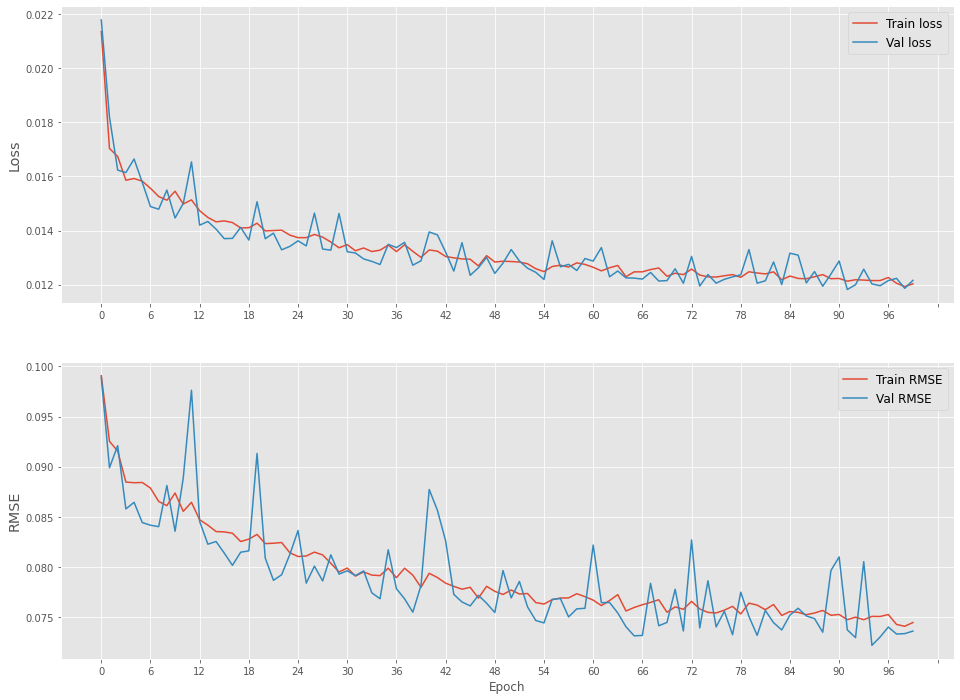

In [20]:
history.plot_training_hist()

In [21]:
best_epoch = np.argmin(history.history['val_loss'])
min_loss = history.history['val_loss'][best_epoch]
min_rmse = history.history['RMSE'][best_epoch]

print(f'Best epoch: {best_epoch}, MSE: {min_loss:.4f}, RMSE: {min_rmse:.4f}')

Best epoch: 91, MSE: 0.0118, RMSE: 0.0748


In [22]:
# Predict some random samples
n_samples = 10
samples_idx = np.random.randint(0, X_test.shape[0], n_samples)

sample_X = X_test[samples_idx]
sample_y = y_test[samples_idx]

preds = model.get_predictions(sample_X)

In [23]:
# Flatten arrays to 1D
preds = preds.ravel()
sample_y = sample_y.ravel()

In [24]:
error_arr = np.zeros(20)

headers = ['Label($)', 'Prediction($)', 'Pct Error']
print(f'{headers[0]} {headers[1]:>20} {headers[2]:>16}')
print('=' * 46)
for i, (label, pred) in enumerate(zip(sample_y, preds)):
    denorm_label = label * (target_max - target_min) + target_min
    denorm_pred = pred * (target_max - target_min) + target_min
    pct_error = (denorm_pred - denorm_label) / denorm_label
    error_arr[i] = np.abs(pct_error)
    print(f'{int(denorm_label):<15} {int(denorm_pred):>6} {pct_error:>23.2%}')

print('=' * 46)
print(f'\nMean percentage error: {np.mean(error_arr):.2%}')

Label($)        Prediction($)        Pct Error
156100          164343                   5.28%
344000          383391                  11.45%
221100          160096                 -27.59%
175500          156215                 -10.99%
113500          129064                  13.71%
500001          423331                 -15.33%
183400          239156                  30.40%
148100          165845                  11.98%
310500          271109                 -12.69%
93400            74697                 -20.02%

Mean percentage error: 7.97%
